In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.utils.mobile_optimizer import optimize_for_mobile

In [2]:
# model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model = models.mobilenet_v3_large(weights = models.MobileNet_V3_Large_Weights.DEFAULT)

In [3]:
""" For MobileNetV3-Small Model """

# model.features[12] = models.mobilenetv3.Conv2dNormActivation(
#     in_channels = 96,
#     out_channels = 512,
#     kernel_size = 1,
#     stride = 1,
#     bias = False,
#     activation_layer = lambda *args, **kwargs: nn.Hardswish()
# )

# model.classifier = nn.Sequential(
#     nn.Linear(in_features=512, out_features=1024, bias=True),
#     nn.Hardswish(),
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1024, out_features=7, bias=True)
# )


' For MobileNetV3-Small Model '

In [4]:
""" For MobileNetV3-Large Model """

model.features[16] = models.mobilenetv3.Conv2dNormActivation(
    in_channels = 160,
    out_channels = 800,
    kernel_size = 1,
    stride = 1,
    bias = False,
    # norm_layer = functools.partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=lambda *args, **kwargs: nn.Hardswish()
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=800, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1024, out_features=7, bias=True)
)

In [5]:
model.load_state_dict(torch.load("pytorch_models/model_large_2_840.pt", weights_only=True))

<All keys matched successfully>

In [6]:
model.eval()

# 2. Create dummy input matching your input size (RGB image: [1, 3, 224, 224])
example_input = torch.randn(1, 3, 224, 224)

# 3. Trace or script the model
# Use tracing only if your model doesn't have control flow (like if-else)
traced_model = torch.jit.trace(model, example_input)

In [6]:
# 4. Export for mobile
mobile_model = optimize_for_mobile(traced_model)

# 5. Save the mobile model for LiteInterpreter module in Java
mobile_model._save_for_lite_interpreter("mobile_models/model_large_int.pt")

In [8]:
# 6. Save the mobile model for Pytorch module in Java
torch.jit.save(traced_model, "mobile_models/model_large.pt")

# Load jit model

In [9]:
import torch
model = torch.jit.load("mobile_models/model_large.pt")

In [10]:
model

RecursiveScriptModule(
  original_name=MobileNetV3
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=Hardswish)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (block): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU)
        )
        (1): RecursiveScriptModule(
          original_name=Conv2dNormActivation
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
        )
      

# Testing the Mobile Model

In [1]:
import torch
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]))
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label   

In [4]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2

data_transforms = {"train" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        weights.transforms()
    ]),
    "val" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [6]:
train_path = "train"
val_path = "val"

train_imgDataset = ImageDataset(img_dir=train_path, transform=data_transforms["train"])
valid_imgDataset = ImageDataset(img_dir=val_path, transform=data_transforms["val"])

In [7]:
label_weights = [3,3,2,5,2,1,4]
train_dataset = AugmentedDataset(train_imgDataset, weights=label_weights)
valid_dataset = AugmentedDataset(valid_imgDataset)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
len(train_loader)

125

In [9]:
model = torch.jit.load("mobile_models/model_large.pt")

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

The device type is: cpu


In [11]:
model = model.to(device)

In [12]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:50<00:00,  2.05it/s]


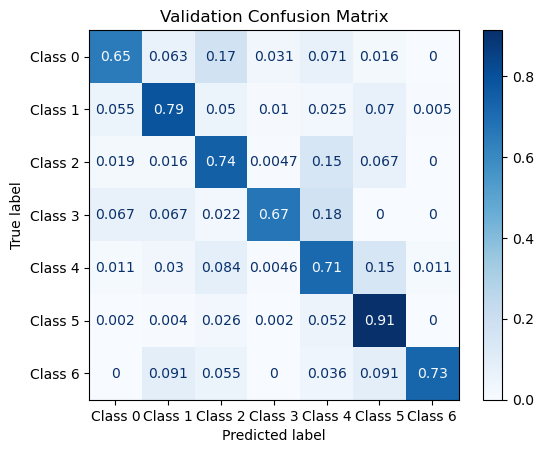


Classification Report:
Total accuracy: 0.839502427184466

         Accuracy  Precision    Recall  F1-Score
Class 0  0.645669   0.725664  0.645669  0.683333
Class 1  0.786070   0.782178  0.786070  0.784119
Class 2  0.744186   0.717489  0.744186  0.730594
Class 3  0.666667   0.681818  0.666667  0.674157
Class 4  0.710046   0.617063  0.710046  0.660297
Class 5  0.913000   0.940752  0.913000  0.926668
Class 6  0.727273   0.869565  0.727273  0.792079


In [13]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:04<00:00,  1.00it/s]


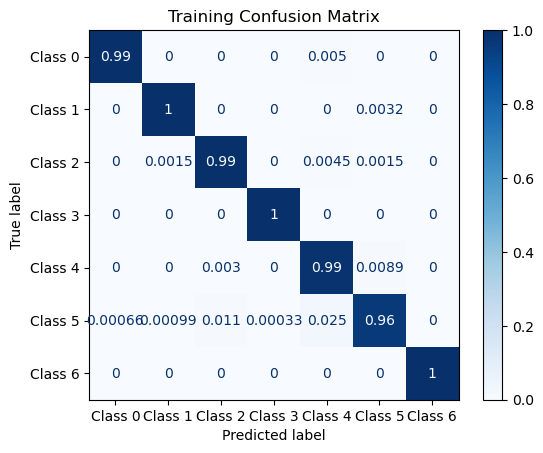


Classification Report:
Total accuracy: 0.9816282874040518

         Accuracy  Precision    Recall  F1-Score
Class 0  0.995000   0.996661  0.995000  0.995830
Class 1  0.996805   0.994687  0.996805  0.995745
Class 2  0.992526   0.972894  0.992526  0.982612
Class 3  1.000000   0.997151  1.000000  0.998573
Class 4  0.988148   0.940762  0.988148  0.963873
Class 5  0.962277   0.994188  0.962277  0.977972
Class 6  1.000000   1.000000  1.000000  1.000000


In [14]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")